In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import example_utils as ex_utils

from MARBLE import utils, geometry, net, plotting, postprocessing

# For initial conditions, sample a rectangle uniformly

In [2]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [3]:
n_steps=20
mu = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = ex_utils.initial_conditions(n, len(mu), area)
for i, m in enumerate(mu):
    p, v = ex_utils.simulate_vanderpol(m, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = ex_utils.parabola(end_point[:,0], end_point[:,1])
    pos[i] = ex_utils.parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot vector fields

In [39]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=20, stop_crit=0.03, vector=True)

---- Embedding dimension: 3
---- Signal dimension: 3



Computing tangent spaces...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 434.87it/s]



Fraction of variance explained:  tensor([0.5878, 1.0000, 1.0000])

---- Manifold dimension: 2


Computing connections...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.20it/s]



---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


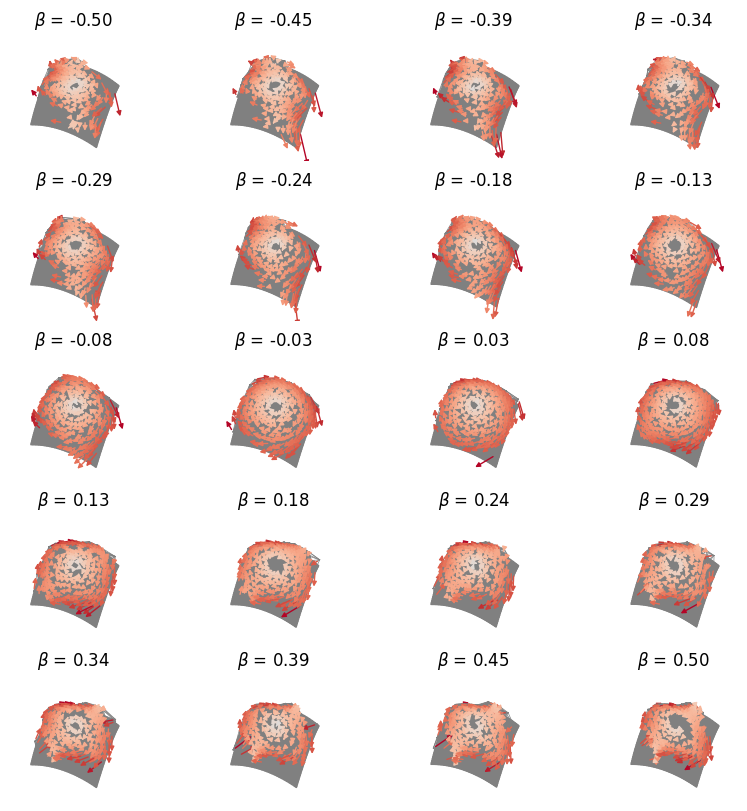

In [5]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]

axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])
for ax in axes:
    ex_utils.plot_parabola(ax)

#plt.savefig('./outputs/parabolas.svg')

# Train network

In [40]:
par = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = net(data, par=par)
model.run_training(data, outdir='./output/vanderpol_data')
#model.load_model('./outputs/vanderpol_data/best_model.pth')


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
dim_man : 2
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  450

---- Training network ...

Epoch: 1, Training loss: 1.371425, Validation loss: 1.3590, lr: 0.0100 *
Epoch: 2, Training loss: 1.341440, Validation loss: 1.3388, lr: 0.0100 *
Epoch: 3, Training loss: 1.314137, Validation loss: 1.3349, lr: 0.0100 *
Epoch: 4, Training loss: 1.295642, Validation loss: 1.2846, lr: 0.0100 *
Epoch: 5, Training loss: 1.301268, Validation loss: 1.2842, lr: 0.0100 *
Epoch: 6, Training loss: 1.291104, Validation loss: 1.2995, lr: 0.0100
Epoch: 7, Training loss: 1.282798, Validation loss: 1.3129, lr: 0.0100
Epoch: 

# Create embeddings

In [41]:
data = model.evaluate(data)
data = postprocessing(data, embed_typ='PCA')

Performed PCA embedding on embedded results.


Performed PCA embedding on embedded results.


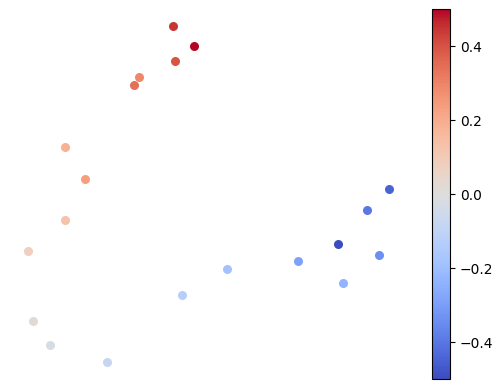

In [42]:
emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'PCA')
plotting.embedding(emb_MDS, mu, s=30, alpha=1)
#plt.savefig('../results/van_der_pol_MDS.svg')
plt.show()

# Distance matrix

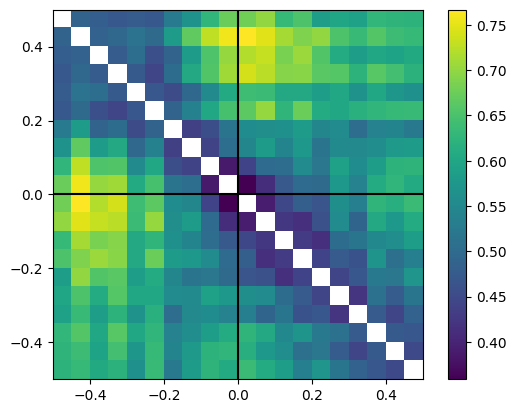

In [47]:
d= data.dist
d += np.diag(np.diag(d)*np.nan)
im = plt.imshow(d, extent=[mu[0], mu[-1], mu[0], mu[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)
#plt.savefig('../results/van_der_pol_D.svg')

# Cluster and visualise embedding

<Axes: >

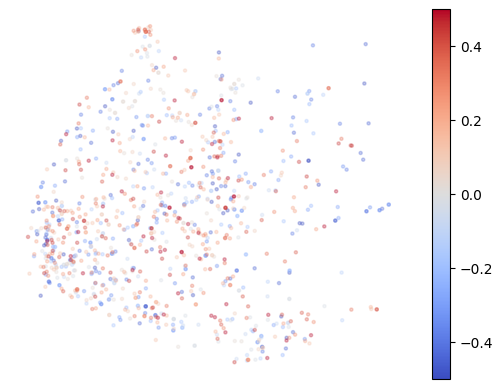

In [46]:
titles = [r'$\beta$ = {:0.2f}'.format(m) for m in mu]
plotting.embedding(data, mu[data.y.numpy().astype(int)])#, titles=titles)
#plt.savefig('../results/van_der_pol_embedding.svg')

In [27]:
mu[data.y.numpy().astype(int)]


array([-0.5, -0.5, -0.5, ...,  0.5,  0.5,  0.5])

In [28]:
data

DataBatch(x=[3991, 3], edge_index=[2, 79933], y=[3991], pos=[3991, 3], edge_weight=[79933], num_nodes=3991, num_node_features=[20], sample_ind=[3991], batch=[3991], ptr=[21], degree=20, number_of_resamples=1, train_mask=[3991], val_mask=[3991], test_mask=[3991], kernels=[3], gauges=[3991, 3, 3], local_gauges=False, out=[3991, 5], emb=[3991, 2], dist=[20, 20], manifold=UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))